 University of Helsinki
 
 Stochastic Methods of Energy Markets Spring 2021
 
 Bernardo Williams

# Final Project

## 1. Historical Calibration

### Introduction
Consider a Lévy Process $Y_t$ of the form $Y_t = \omega t + \theta G_t + \sigma W(G_t)$ where $W_t$ is the usual Wienner process and $G_t$ is a Gamma process such that
$$
\begin{align*}
\mathbb{E}G_t &= t \\ 
Var(G_t) &= \nu t \\ 
\end{align*}
$$
Note that for a fixed time $t$ then $G_t$ follows a gamma distribution with shape $\alpha=\frac{t}{\nu}$ and rate $\beta=\frac{1}{\nu}$, namely
$G_t\sim Gamma(\alpha=\frac{t}{\nu}, \beta=\frac{1}{\nu})$

In this exercise we will model the asset $F_t$ by the following dynamics
$$
d\log F_t = \theta d G_t + \sigma d W(G_t)
$$
namely, $F_t = F_0 e^{Y_t}$



### Maximum Likelihood Estimation
Assume we have a data sample $(x_1,...,x_n)$ and a time grid $t_1,...,t_n$ with a constant increment $\Delta t = t_{i+1}-t_i$. Define $X_t = \log F_{t_i} - \log F_{t_{i-1}}$. 
Since $Y_t$ is process with stationary and independent increments then the likelihood function over the timegrid of $X_t$ is 
$$
    L(\theta) = \Pi_{i=1}^n f_{X(t_i)|\theta}
$$
And the maxim likelihood parameters are such that they maximize the likelihood function evaluated on the data. Or equivalently, the parameters such that the log likelihood is maximized.
$$
\hat{\theta}_{ML} = \textrm{argmax}_\theta \sum_{i=1}^n \log f_\theta(x_i)
$$
It can be shown that the density of $X_t$ evaluated at a point $x$ is 
$$
f_\theta(x) = \frac{ 2e^{\frac{\theta x}{\sigma^2} } } { \sigma \sqrt{2\pi} \nu^{\Delta t \nu } \Gamma(\frac{1}{\nu} ) }
\left(
\frac{|x|}{\sqrt{\frac{2\sigma^2}{\nu} + \theta^2}}
\right)^{\frac{\Delta t}{\nu} - \frac{1}{2} }
K_{\frac{\Delta t}{\nu} - \frac{1}{2} } 
\left(
\frac{|x|\sqrt{\frac{2\sigma^2}{\nu} + \theta^2}}
{\sigma^2}
\right)
$$
Where $\Gamma(x)$ is the Gamma funciton and $K_\eta(x)$ is the modified Bessel function of the second kind. 

We implement the likelihood function in code and fit it to the log-returns of German Forwards for the calendar year $2021$. In order maximize the likelihood given the data we need an optimizer and a starting point for the optimizer. As the function has local maximums the choice of the initial point might affect the convergence of the optimizer. Now we discuss a way to choose ''good'' initial values



#### Initial Parameters
In order to address the problem of local maxima, we decided to start the optimizer at the parameters given by the method of momments, this is computing the first four central momments of $X_t$ and then solving for the parameters in terms of the variance, kurtosis and skewness. 

As $X_t$ is a variance gamma process with parameters $\theta$, $\sigma$ and $\nu$ at time $\Delta t$, thus the momment generating function is
$$
M_X(u, t) = (1-\theta \nu u - \frac{1}{2} \nu \sigma^2 u^2)^{\frac{-\Delta t}{\nu}}
$$
The first 4 central momments are computed to be
$$
\begin{align*}
\mathbb{E}X &=  \theta \Delta t \\
\mathbb{E}(X - \mathbb{E}X)^2 &= ( \nu\theta^2+\sigma^2) \Delta t \\
\mathbb{E}(X - \mathbb{E}X)^3 &= ( 2\theta^3\nu^2+3\sigma^2\nu \theta) \Delta t \\
\mathbb{E}(X - \mathbb{E}X)^4 &= 
 ( 3\nu \sigma^2 + 12\theta^2\sigma^2\nu^2 + 6\theta^4\nu^2 ) \Delta t
 + ( 3\sigma^4 \theta + 6\theta^2\sigma^2\nu  + 3\theta^4\nu^2) \Delta t^2
\end{align*}
$$

Now we use the notation for $M$ mean, $V$ variance, $S$ skewness and $K$ kurtosis. Note that this values can be computed from the data $x_1,...,x_n$, from which the starting points will be obtained
$$
\begin{align*}
M=\mathbb{E}X \\
V=\mathbb{E}(X - \mathbb{E}X)^2 \\
S = \frac{\mathbb{E}(X - \mathbb{E}X)^3 }{ V^{\frac{3}{2}}   }\\
K = \frac{\mathbb{E}(X - \mathbb{E}X)^4 }{ V^{2}   }\\
\end{align*}
$$
And furtherly assuming that $\theta$ is ''small´´ as it usually is in applications, we get the starting values:
$$
\begin{align*}
\sigma_0 &= \sqrt{\frac{V}{\Delta t}} \\
\nu_0 &=    \left( \frac{K}{3}-1  \right)\Delta t \\
\sigma_0 &= \frac{S\sigma \sqrt{\Delta t}}{3\nu} \\
\end{align*}
$$

### Fitting the data by MLE
We load the DEBY data and compute the log-returns. We print basic summary statistics, plot the partial autocorrelation function and a qqplot. 

The empirical mean is close to zero, the variance is small and the kurtosis is $K=6.43$ which is much bigger than a standar normal distribution which has kurtosis of $3$, which tells us that the tails are heavier than a normal distribution.

From the **PACF** we can see that for any lag greater than one there is no autocorrelation dependence, as no bars lie far outside of the $95\%$ confidence intervals. 

The **qqplot** shows that tails are heavier than a normal distribution so a Gamma-variance Lévy process is a good choice for modelling. 

The code and plots are below.



In [21]:
import os 
import pandas as pd
import numpy as np
from scipy.stats import kurtosis, skew
from scipy.optimize import minimize
from scipy.special import gamma, kv 
from  numpy import pi
import matplotlib.pyplot as plt


def load_process_data(work_dir):
    os.chdir(work_dir)
    df_raw = pd.read_csv('data/Historical_Prices_FWD_Germany.csv')
    df_raw['date'] = pd.to_datetime(df_raw['Data'])
    df_GF = df_raw[df_raw['date']<='2019-11-19'][['date','DEBY2021']]    
    df_GF['log_ret'] = np.log(df_GF['DEBY2021']) - np.log(df_GF['DEBY2021'].shift(1))   
    # Remove where increment is zero to avoid errors
    df =df_GF[(~df_GF['log_ret'].isna()) & (df_GF['log_ret']!=0)]
    return df


def momment_matching_vg_params(data, dt):
    # M = np.mean(data);
    # Matlab uses biased estimator
    V = np.var(data, ddof=1);
    S = skew(data);
    # scipy substracts 3 (the normal distr kurtosis ) by default
    K = kurtosis(data) + 3;
    sigma = np.sqrt(V/dt);
    nu = (K/3 -1)*dt;
    theta = (S* sigma * np.sqrt(dt))/(3* nu );
    return theta, sigma, nu


def VGdensity_2(x, theta, nu, sigma, T):
    v1 = 2* np.exp(( theta*(x))/sigma**2) / ( (nu**(T/nu)) * np.sqrt(2*pi) * sigma * gamma(T/nu) );
    M2 = (2* sigma**2)/ nu + theta**2;
    v3 = np.abs(x)/ np.sqrt(M2 );   
    v4 = v3**(T/nu - 0.5) ;
    v6 = (np.abs(x)* np.sqrt(M2))/ sigma**2;
    K = kv(T/nu - 0.5 , v6 );
    fx = v1 * v4 *K;
    return fx



def mle_estimation(data, params, seed=42):
    np.random.seed(seed)
    # maximum likelihood estimation    
    neg_loglikelihood = lambda params: -np.sum(np.log(VGdensity_2(data, params[0], params[1], params[2], dt)))
    output = minimize(neg_loglikelihood, params, method = 'Nelder-Mead' )
    print(output)
    return output['x']


def plot_mle_fit():
    x = np.linspace(np.min(data), np.max(data), 500)
    fx_st = VGdensity_2(x, theta, nu, sigma, dt)
    fx_mle = VGdensity_2(x, mle_params[0], mle_params[1], mle_params[2], dt)
    
    
    fig, ax1 = plt.subplots()
    ax1.set_ylim([0, 110])
    plt.hist(data, bins = 50, edgecolor='black', alpha=0.3, color='green', label='Market data')
    plt.legend(loc='best')
    
    ax2 = ax1.twinx() 
    ax2.set_ylim([0, 70])
    plt.plot(x, fx_st, color='red', label='Method of Momments')
    plt.plot(x, fx_mle, color='green', label='MLE fit')
    # fig.tight_layout() 
    plt.legend(loc='best')
    plt.show()
    
# Data Analysis 
def plot_data():
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
    ax1.plot(df['date'], df['DEBY2021'], label='German Forward Prices')
    ax1.set_title('German Forward Prices')
    ax2.plot(df['date'], df['log_ret'], label='Log Returns', color='red', alpha=0.5)
    ax2.set_title('Log Returns')
    plt.xticks(rotation=90)
    plt.show()
    


    

Mean:  0.0007433405387152798
Variance:  0.0007433405387152798
Skewness:  -0.22657573932847785
Kurtosis:  6.4315069887584615


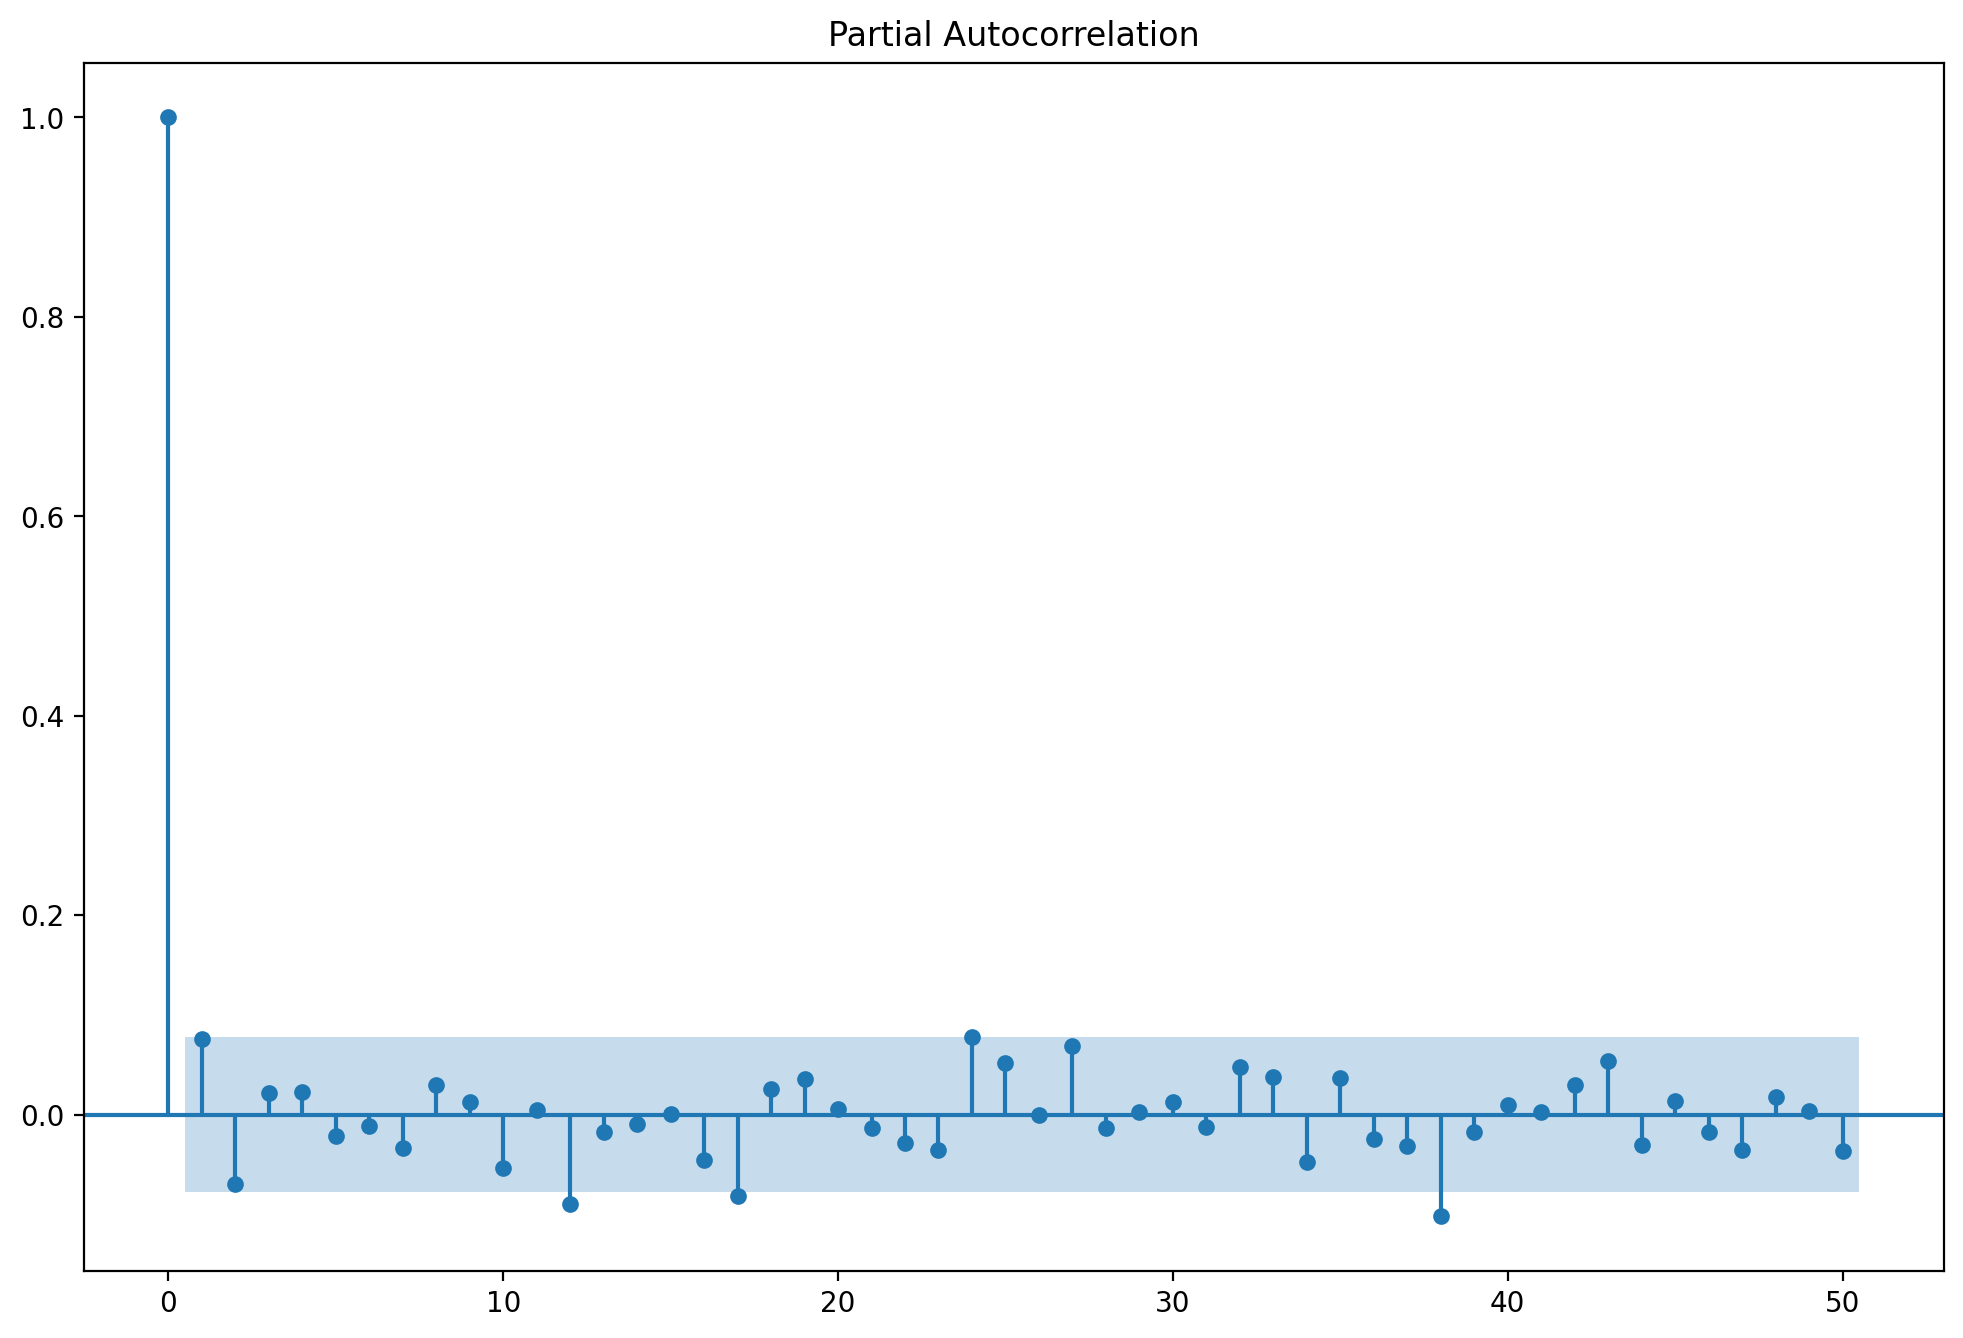

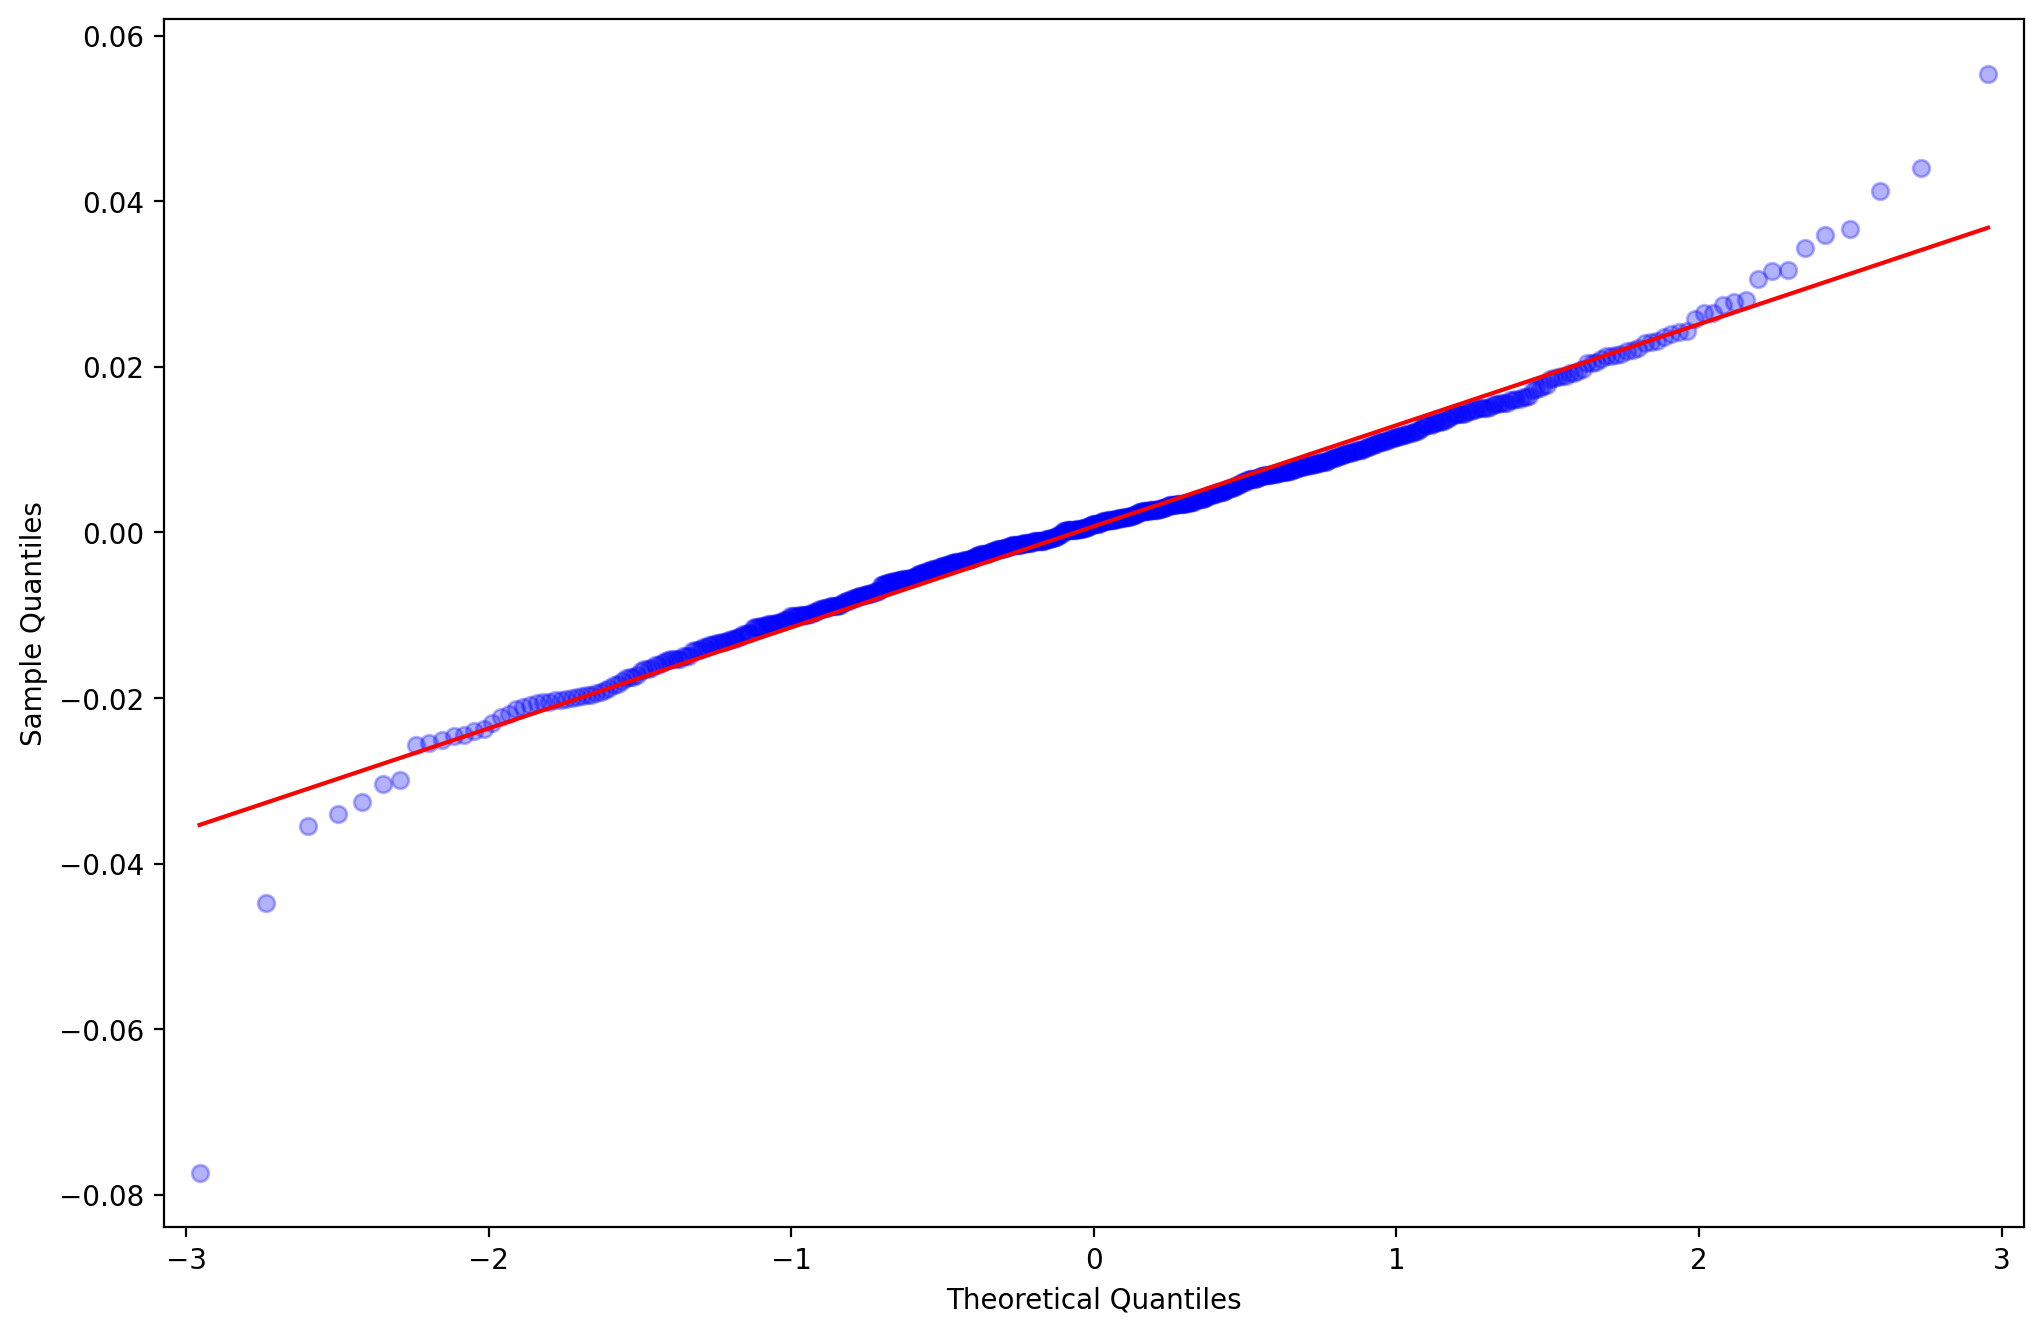

In [24]:

work_dir = '/Users/bwilliams/GoogleDrive/UniversityOfHelsinki/Spring2021/SMFOEM/Week7/Project_BW'
df = load_process_data(work_dir)

dt = 1/252;
data = df['log_ret']


# Basic statistics log returns    
M = np.mean(data);
# Matlab uses biased estimator
V = np.var(data, ddof=1);
S = skew(data);
# scipy substracts 3 (the normal distr kurtosis ) by default
K = kurtosis(data) + 3;

print('Mean: ',M)
print('Variance: ',M)
print('Skewness: ',S)
print('Kurtosis: ',K)

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.gofplots import qqplot
plot_pacf(data, lags=50)
plt.show()

qqplot(data, line = 's', alpha=0.3)
plt.show()

#### Plotting the ML fit
Finally let's see how the data was fitted using the initial parameters found by the method of momments and then by the ML-estimation of the parameters, we can see that the ML-parameters are true to the empirical distribution of the data (histogram) than the parameters found by the method of momments. Note that we found the same $ML$ parameters as where found by Matteo Gardini.

| $\hat{\theta}_0$ | $\hat{\sigma}_0$ | $\hat{\nu}_0$ |
|---|---|---|
| -0.2032 | 0.19394 |  0.004539 |

| $\hat{\theta}_{ML}$ | $\hat{\sigma}_{ML}$ | $\hat{\nu}_{ML}$ |
|---|---|---|
| 0.1873 |  0.1916 | 0.001983 |






 final_simplex: (array([[0.18730875, 0.00198363, 0.19168433],
       [0.18740309, 0.00198345, 0.19168291],
       [0.18728302, 0.00198316, 0.19167855],
       [0.18734183, 0.0019835 , 0.1916864 ]]), array([-1930.3677172 , -1930.36771706, -1930.36771704, -1930.36771698]))
           fun: -1930.3677172032806
       message: 'Optimization terminated successfully.'
          nfev: 135
           nit: 75
        status: 0
       success: True
             x: array([0.18730875, 0.00198363, 0.19168433])
Method of momments parameters:  [-0.20328199  0.00453903  0.19394122]
MLE fit parameters:  [0.18730875 0.00198363 0.19168433]


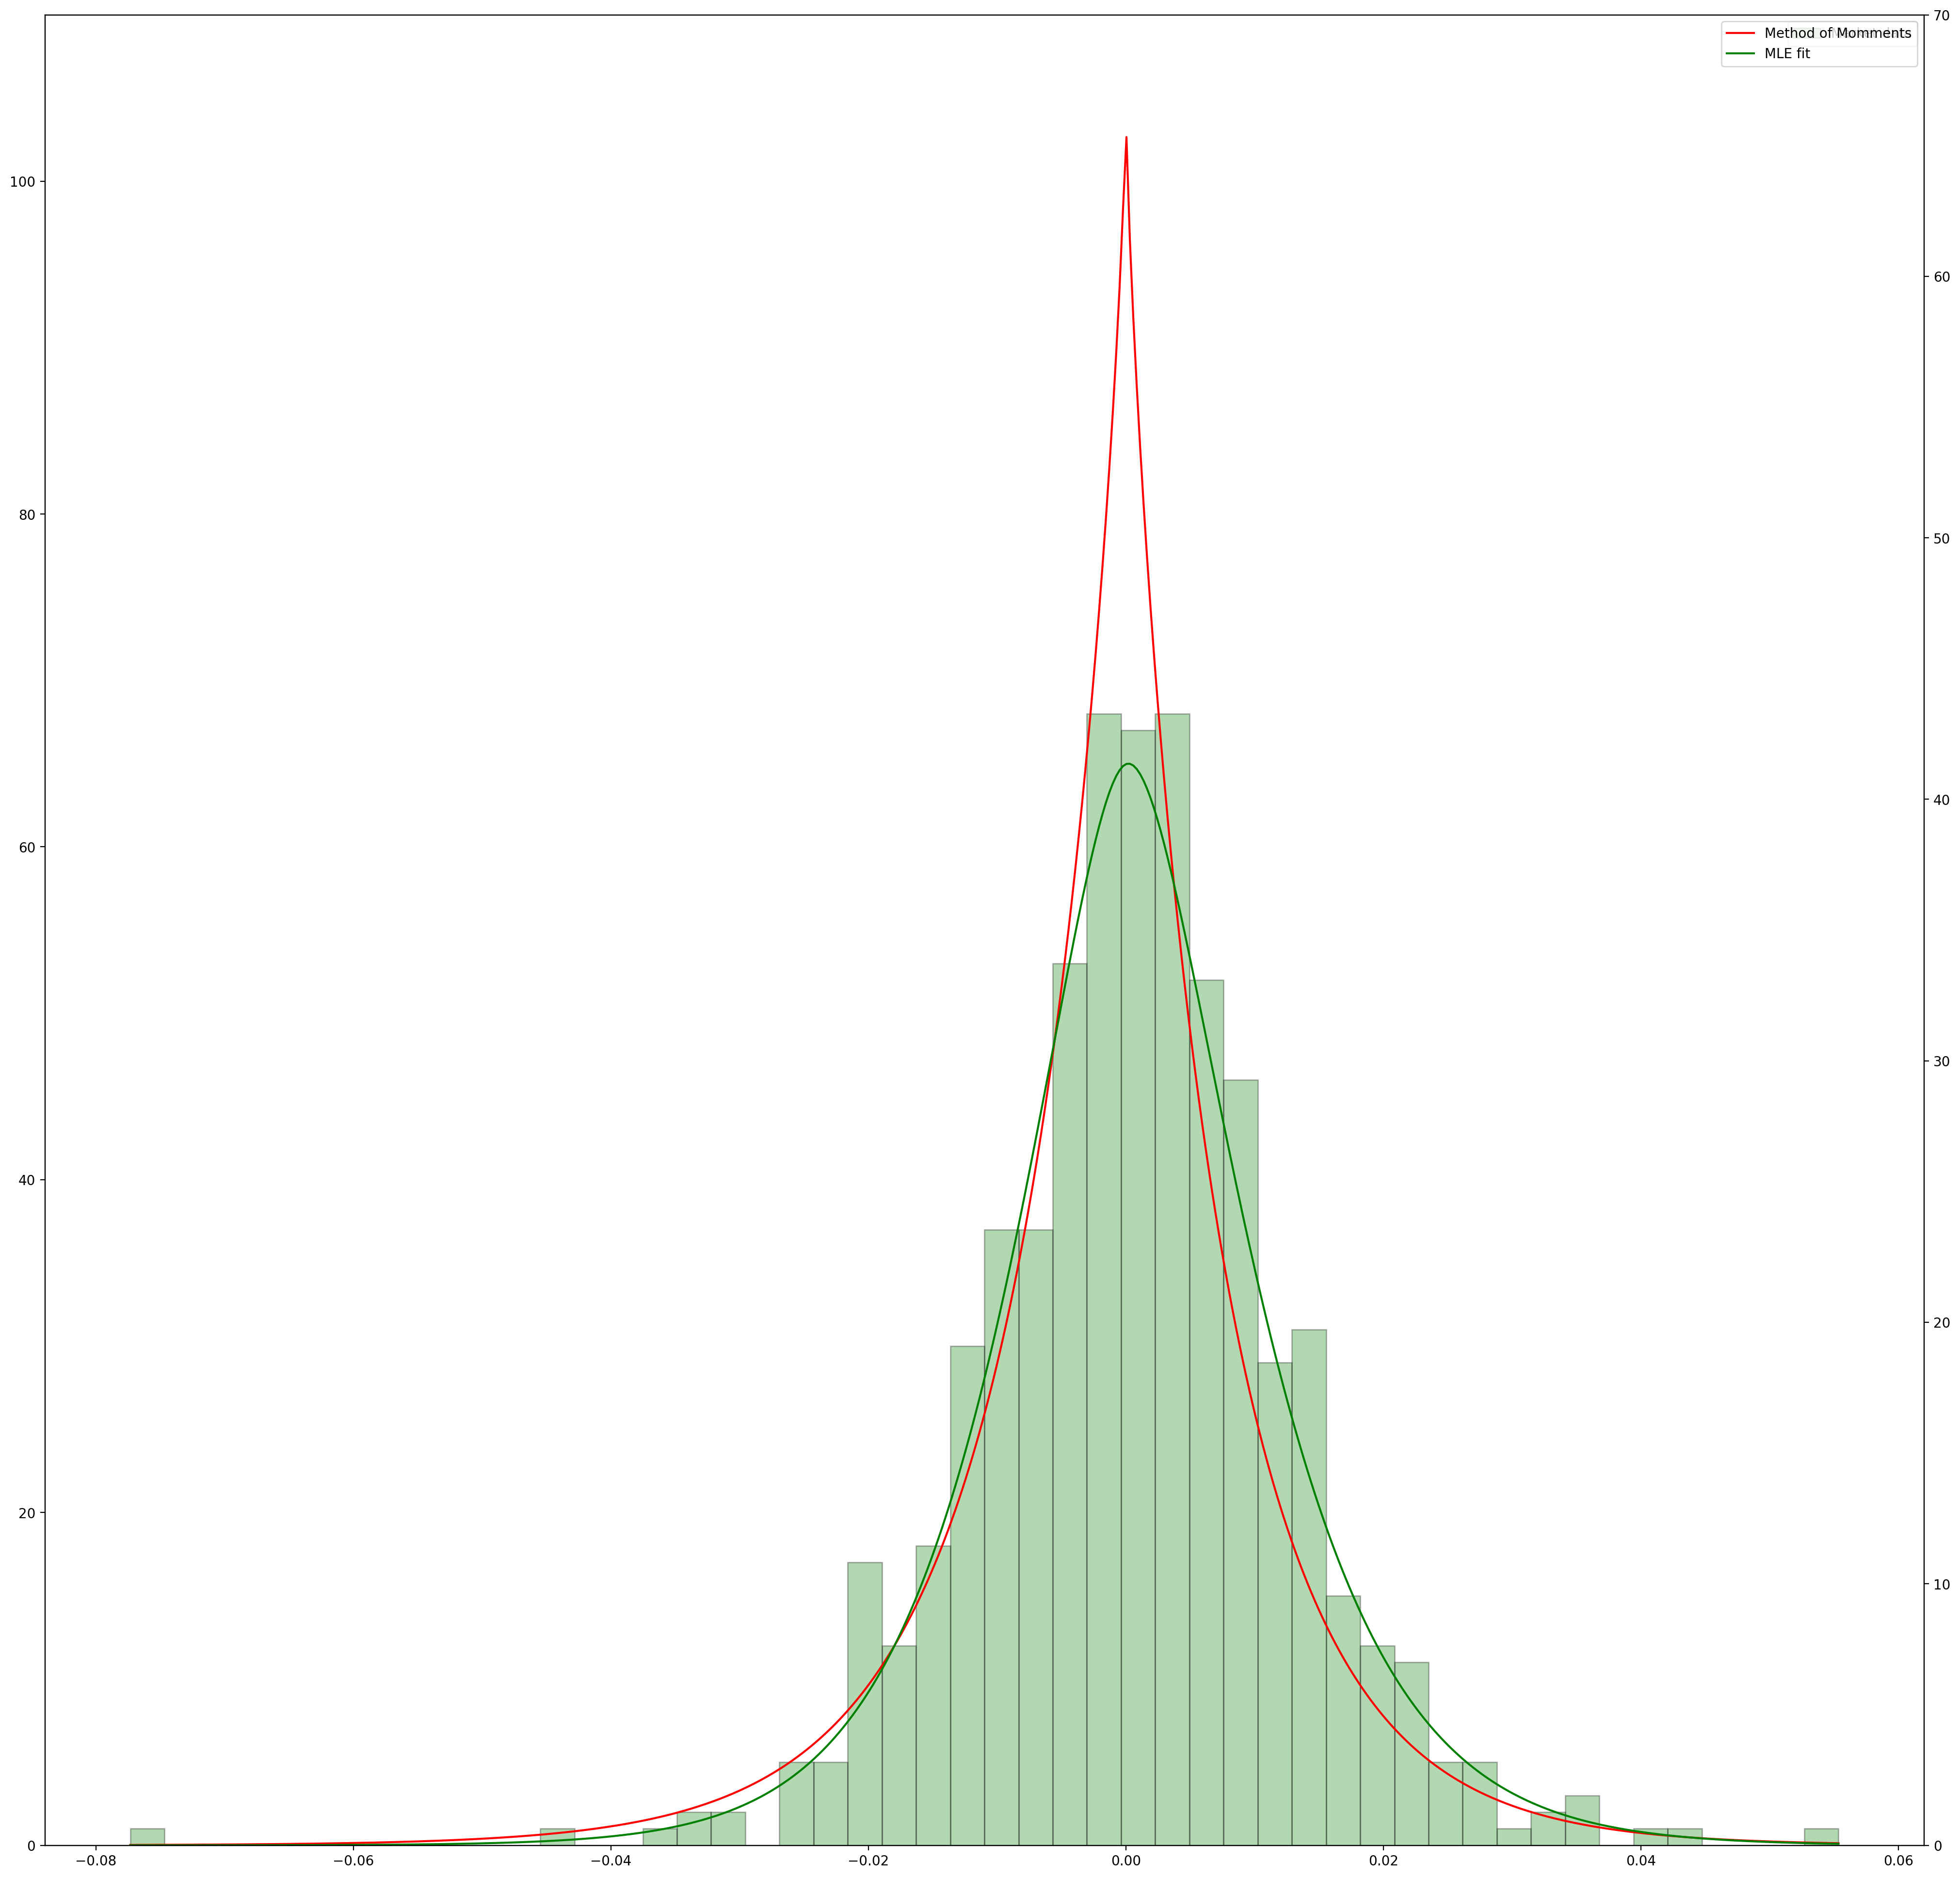

In [23]:
# MLE estimation
theta, sigma, nu = momment_matching_vg_params(data, dt)
params = np.array([theta, nu, sigma])
mle_params = mle_estimation(data, params)

print('Method of momments parameters: ', params)
print('MLE fit parameters: ', mle_params)

plot_mle_fit()



## 2. Risk Neutral Calibration

### Calibration by ordinary least squares
In this approach the parameters $\theta$, $\sigma$ and $\mu$ of the model will be calibrated by minizing the squared difference between call options data and estimated call option price, given the parameters $F_0$, $r$, $T$, $K$ which are respectively the forward price at time zreo, the interst free rate, the expiration date and the strike price. Namely, we wish to minimize
$$
\sum_{i=1}^n (C_i - C^{\Theta}_i(F_0,r,T,K))^2
$$
Where $\Theta$ refers to the vector of parameters $\Theta=(\theta, \sigma, \nu)$.

In order to find the value of the call option $C^{\Theta}$ at time $t_0$ given the model, first we need some preliminary result. In a risk free market, $F_t$ is a martingale, so for which value of $\omega$ is $F_t=F_0e^{\omega t + \theta G_t + \sigma W(G_t)}$ a margingale?

#### Proposition: $F_t$ is a martingale if $\omega = \frac{1}{\nu} \log(1-\frac{\sigma^2\nu}{2}-\theta v)$
**Sketch of proof**
Consider $0<s<t$ and the natural filtration $\{\mathcal{F}_t\}_{t\geq 0}$, then  the martingale condition states that $\mathbb{E}(F_t|\mathcal{F}_s) = F_s$
$$
\begin{align*}
\mathbb{E}(F_t|\mathcal{F}_s) ) &=   \mathbb{E}( F_0 \exp( w(t-s +s) + \theta (G_t-G_s+G_s) + \sigma(W(G_t)-W(G_s)+W(G_s))|\mathcal{F}_s)  \\
 &= F_s \mathbb{E}(F_{t-s}|\mathcal{F}_s) ) \\
 &= F_s e^{w(t-s)}\mathbb{E}(e^{Y_{t-s}}) ) \\
\end{align*}
$$
The last equality from the fact that $W_t$ and $G_t$ have stationary and independent increments, if $M_Y(u,t)$ is the moment generrating function of $Y_t$ at $u$ then the above is equivalent to
$$
e^{w(t-s)} = M_Y(1,t-s)
$$
Remember that the MGF for the gamma-variance process $Y_t$ is
$$
M_Y(u,t) = (1-\theta \nu u - \frac{1}{2} \nu \sigma^2 u^2)^{\frac{-t}{\nu}}
$$
therefore, for $F_t$ to be a martingale
$$
-\omega(t-s) = \frac{t-s}{\nu} \log(1-\theta \nu  - \frac{1}{2} \nu \sigma^2 )
$$
and finally $\omega =  \frac{1}{\nu} \log(1-\theta \nu  - \frac{1}{2} \nu \sigma^2 )$

Now that we've found the value of $\omega$ such that $F_t$ is a martingale, how can we compute the value of the call option $C^{\Theta}$ for the given parameters? First, let's recap the Black 76 model which we'll need in the computation of $C^\theta$.

#### Black 76 Model 
Given a risk free rate $r$, a time to maturity $T$, a strike price $K$, an underlying forward contract $F_t$ with price $F_0$ at valuation and a call option $C_t$ such that $F_t$ follows the gbm dynamics
$$
dF_t =\mu F_t dt+ \sigma F_t dW_t
$$
with solution 
$$
\begin{align*}
F_t &= F_0 \exp({(\mu-\frac{\sigma^2}{2})t+\sigma W_t}) \\
 &\overset{d}{=} F^{'}_0\exp({-\frac{V_t}{2} + \sqrt{V_t} Z})
\end{align*}
$$ 
where $F^{'}_0 = F_0 e^{\mu t}$,  $V_t=\sigma^2 t$ and $Z\sim N(0,1)$. $V_t$ is called terminal variance.

The Black 76 model states that the valuation of a call contract is
$$
\begin{align*}
 C_0 &= e^{-rT}\mathbb{E}[(F_t-K)^{+}] \\
     &=  e^{-rT} (F^{'}_0 N(d_1) - K N(d_2)  )
\end{align*}
$$
where
$$
d_1 = \frac{\log(\frac{F^{'}_0}{K})+\frac{V_T}{2}}{\sqrt{V_T}}
$$
$$
d_2 = d_1 - \sqrt{V_T}
$$
and $N(d_1)$ is the cumulative distribution of $Z$ evaluated at $d_1$.

#### Valuation of call options in variance-gamma model
Remember the model is $F_t = F_0\exp(\mu t \theta G_t + \sigma W(G_t))$, then the valuation of a call option with time to maturity $T$, strike $K$ and risk free rate $r$ is 

$$
C_0 = e^{-rT}\mathbb{E}[(F_0\exp(\mu t+ \theta G_t + \sigma W(G_t))-K)^{+}] 
$$

By the tower of property of conditional expectation conditioning on the value of $G_t$

$$
\begin{align*}
C_0 &=  e^{-rT} \mathbb{E}[  \mathbb{E}[(F_0\exp(\mu t+ \theta G_t + \sigma W(G_t))-K)^{+}|G_t=g ]]\\
 &= e^{-rT} \int_{0}^\infty f_G(g,T) \mathbb{E}[(F_0\exp(\mu t + \theta g + \sigma W(g))-K)^{+}|G_t=g ] dg \\ 
 &\overset{d}{=}
 e^{-rT} \int_{0}^\infty f_G(g,T) \mathbb{E}[(F_0\exp(\mu t + \theta g +   
 \frac{\sigma^2}{2}g - \frac{\sigma^2}{2}g +
 \sigma \sqrt{g}Z)-K)^{+}|G_t=g ] dg \\
\end{align*}
$$
Where $f_G(g,T)$ is a density of a $Gamma(\frac{T}{\nu},\frac{1}{\nu})$ distribution.

So defining: 
$$
\begin{align*}
F_g &= F_0 \exp(\mu T + g(\theta + \frac{\sigma^2}{2}))\\
V_g &= \sigma^2 g
\end{align*}
$$
we end up getting
$$
C_0 = \int_{0}^\infty f_G(g,T) B_{76}(F_g, K, V_g, r,T)dg
$$


#### Fit of OLS model
Now that we have an analyitical formula for $C^\Theta$ we can implement it in code and find parameters 
$\Theta = (\theta, \nu, \sigma)$ such that they minize the sum of square errors
$$
\hat{\Theta}_{OLS} = \textrm{argmin}_{\Theta}\sum_{i=1}^n (C_i - C^{\Theta}_i(F_0,r,T,K))^2
$$
First we load the data and filter call options corresponding to `DEBY 2021.01`, and the also the forward the same product to get $F_0$ and the time of valuation.

We write function for `BS-76` implementation, an integrator for valuation the call option $C^\Theta$ and an optimizer over the sum of squares errors. The code can be found below.

The parameters found are:

| $\hat{\theta}_{OLS}$ | $\hat{\sigma}_{OLS}$ | $\hat{\nu}_{OLS}$ |
|---|---|---|
|-0.0512 |  0.2552|  0.5468|

**Note:** The optimizer takes around 4hrs to converge, startin on the parameters found by the method of momments.

In [1]:
import os 
import pandas as pd
import numpy as np
from scipy.stats import norm, gamma
from scipy.integrate import quad
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import sys
from datetime import datetime 

def load_process_data(work_dir):
    os.chdir(work_dir)
    dfopt_raw = pd.read_csv('data/Options_Prices_Calendar_2021.csv')
    dffwd_raw = pd.read_csv('data/Forward_Prices.csv',  dtype={'DeliveryPeriod': object})
    
    
    dfopt_raw['ExpiryDate'] = pd.to_datetime(dfopt_raw['ExpiryDate'])
    dffwd_raw['TradingDate'] = pd.to_datetime(dffwd_raw['TradingDate'])
    
    # Take the calendar Fwd
    df_opt = dfopt_raw[(dfopt_raw['Underlying'] == 'DEBY 2021.01')&(dfopt_raw.Type == 'C')]
    # Take the 2021
    df_fwd = dffwd_raw[(dffwd_raw.Contract == 'DEBY') & (dffwd_raw.DeliveryPeriod=='2021.01') ]
    
    # Remove where increment is zero to avoid errors
    
    return df_opt, df_fwd


def black_76_call( fs, k, t, r, V):
    # Inputs: option_type = "p" or "c", fs = price of underlying, x = strike, t = time to expiration, r = risk free rate
    #          v = implied volatility

    # t__sqrt = math.sqrt(t)
    # d1 = (math.log(fs / x) + (b + (v * v) / 2) * t) / (v * t__sqrt)
    # d2 = d1 - v * t__sqrt
    eps = np.finfo(float).eps
    
    if fs>np.finfo('float').max:
        fs = np.finfo('float').max
    
    
    if V < eps:
        d1 = np.inf
        d2 = np.inf
        

    else:
        d1 = (np.log(fs / k) + V/2) / np.sqrt(V)
        d2 = d1 - np.sqrt(V)
        
    value = fs * np.exp((- r) * t) * norm.cdf(d1) - k* np.exp(-r * t) * norm.cdf(d2)
    
    return value


# Model Calibration

# I need to implement call option pricing by integrating  BS-76 multiplied by gamma density 
# and then find parameters that minimize squared difference


def squared_loss_calibration(df_opt, df_fwd, params):

    F0 = float(df_fwd.SettlementPrice)
    r = 0.01
    t0 = df_fwd.TradingDate.values[0]
    maturities = df_opt.ExpiryDate
    T = (maturities - t0).dt.days/365
    K = df_opt.Strike
    P = df_opt.SettlementPrice    

    theta = params[0]
    nu = params[1]
    sigma = params[2]

    def integrator(g):
        Fg = F0*np.exp(omega*t + g*(theta+sigma**2/2))
        Vg = sigma**2*g
        
        gamma_pdf= gamma.pdf(g, a = t/nu, scale = nu)
        bs_76 = black_76_call( Fg, k, t, r, Vg)
        
        eps = sys.float_info.min
        
        if (gamma_pdf < eps) | (bs_76< eps):
            return 0
        
        if bs_76> sys.float_info.max:
             bs_76 = sys.float_info.max
        
        value = gamma_pdf * bs_76
        return value


    error = np.zeros(len(T))
    ci_ols = np.zeros(len(T))
    for i in range(len(T)):
        t = T.iloc[i]
        k = K.iloc[i]
        ci = P.iloc[i]    
        
        omega = (1/nu)*np.log(1-sigma**2*nu/2-theta*nu) 
        
        integral = quad(integrator, 0.0, np.inf)
        
        ci_theta = integral[0]
        
        error[i] = (ci - ci_theta)**2
        ci_ols[i] = ci_theta
    return error,  ci_ols 

def target_function(params):
    error, _ = squared_loss_calibration(df_opt, df_fwd, params)
    return np.sum(error)


def ols_estimation(df_opt, df_fwd, params, bnds, seed=42):
    vInicio = datetime.now()
    np.random.seed(seed)
    # , options = dict(maxiter = 10)
    output = minimize(target_function, params, bounds = bnds )                     
    vFin = datetime.now()
    print("--- %s seconds ---" % (vFin - vInicio).total_seconds())   
    print(output)
    return output['x']



def plot_prices():
    
    # One plot for each maturity
    error_ols, P_ols =  squared_loss_calibration(df_opt, df_fwd, ols_params)
    

    t0 = df_fwd.TradingDate.values[0]
    maturities = df_opt.ExpiryDate
    T = (maturities - t0).dt.days/365
    K = df_opt.Strike
    P = df_opt.SettlementPrice    
    dif_Ps = P_ols-P
    
    Tunique = np.unique(T)
    
    fig, axs = plt.subplots(2, 2)
    axs[0, 0].set_title('Maturity  in years '+ str(round(Tunique[0],2)) )
    axs[0, 0].scatter(K[T==Tunique[0]], P_ols[T==Tunique[0]], label = 'OLS Call Prices', marker='x', alpha=0.5, s=5)
    axs[0, 0].scatter(K[T==Tunique[0]], P[T==Tunique[0]], label = 'Mkt Call Prices', alpha=0.5, s=5)
    axs[0, 0].scatter(K[T==Tunique[0]], dif_Ps[T==Tunique[0]], label = 'Difference', marker='x', alpha=0.5, s=5)
    axs[0, 0].legend()
    
    axs[0, 1].set_title('Maturity  in years '+ str(round(Tunique[1],2)) )
    axs[0, 1].scatter(K[T==Tunique[1]], P_ols[T==Tunique[1]], label = 'OLS Call Prices', marker='x', alpha=0.5, s=5)
    axs[0, 1].scatter(K[T==Tunique[1]], P[T==Tunique[1]], label = 'Mkt Call Prices', alpha=0.5, s=5)
    axs[0, 1].scatter(K[T==Tunique[1]], dif_Ps[T==Tunique[1]], label = 'Difference', marker='x', alpha=0.5, s=5)
    axs[0, 1].legend()
    
    axs[1, 0].set_title('Maturity  in years '+ str(round(Tunique[2],2)) )
    axs[1, 0].scatter(K[T==Tunique[2]], P_ols[T==Tunique[2]], label = 'OLS Call Prices', marker='x', alpha=0.5, s=5)
    axs[1, 0].scatter(K[T==Tunique[2]], P[T==Tunique[2]], label = 'Mkt Call Prices', alpha=0.5, s=5)
    axs[1, 0].scatter(K[T==Tunique[2]], dif_Ps[T==Tunique[2]], label = 'Difference', marker='x', alpha=0.5, s=5)
    axs[1, 0].legend()
    
    axs[1, 1].set_title('Maturity  in years '+ str(round(Tunique[3],2)) )
    axs[1, 1].scatter(K[T==Tunique[3]], P_ols[T==Tunique[3]], label = 'OLS Call Prices', marker='x', alpha=0.5, s=5)
    axs[1, 1].scatter(K[T==Tunique[3]], P[T==Tunique[3]], label = 'Mkt Call Prices', alpha=0.5, s=5)
    axs[1, 1].scatter(K[T==Tunique[3]], dif_Ps[T==Tunique[3]], label = 'Difference', marker='x', alpha=0.5, s=5)
    axs[1, 1].legend()
    
    plt.show()
    


In [2]:
work_dir = '/Users/bwilliams/GoogleDrive/UniversityOfHelsinki/Spring2021/SMFOEM/Week7/Project_BW'
df_opt, df_fwd = load_process_data(work_dir)


In [3]:
params_mm = np.array( (-0.20328199035811578, 0.19394121669473757, 0.004539030408410662) )
param_matteo = np.array((1.05, 0.02, 0.2))

bnds = ((-2.7, 2.7), (0.001, 0.8), (0.0001, 1.1) )
ols_params = ols_estimation(df_opt, df_fwd, params_mm, bnds)

<ipython-input-1-0d27d4603c1b>:49: RuntimeWarning: divide by zero encountered in log
  d1 = (np.log(fs / k) + V/2) / np.sqrt(V)
<ipython-input-1-0d27d4603c1b>:78: RuntimeWarning: overflow encountered in exp
  Fg = F0*np.exp(omega*t + g*(theta+sigma**2/2))


--- 13575.193405 seconds ---
      fun: 7.370564133189717
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.70352621e-04, -2.29150031e-05, -1.38733469e-04])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 208
      nit: 33
     njev: 52
   status: 0
  success: True
        x: array([-0.05121472,  0.54680289,  0.25529896])


In [6]:
error_ols, P_ols =  squared_loss_calibration(df_opt, df_fwd, ols_params)

## 3. Comparing results and final observations

Finally, we plot the market call option prices for `DEBY 2021.01` against the estimated values found by minizing squared errors, and the difference between these two curves for each of the 4 distinct maturities present in the data. Looking at the difference curve, and comparing them against the ones obtained by Matteo Gardidni, we can see that although the parameters obtained are very different from his, the difference curve is very simmilar to the ones found by him, they follow the same pattern and are about the same size. 

I find it difficult to compare the ML model and the OLS model, as one deals with the problem of finding the parameters such that they maximize the likelihood of the forward prices given a gamma-variance model. In the second model the problem becomes, under the same dynamics, finding the parameters such that the observed call prices and the estimation of the call prices is minimized. We can see that the parameters found are different by ML and by OLS. I think that in order to compare further the two models we could to compute the Call option prices with $\Theta_{ML}$, measure the square error, and compare it with the one found by $\Theta_{OLS}$. 


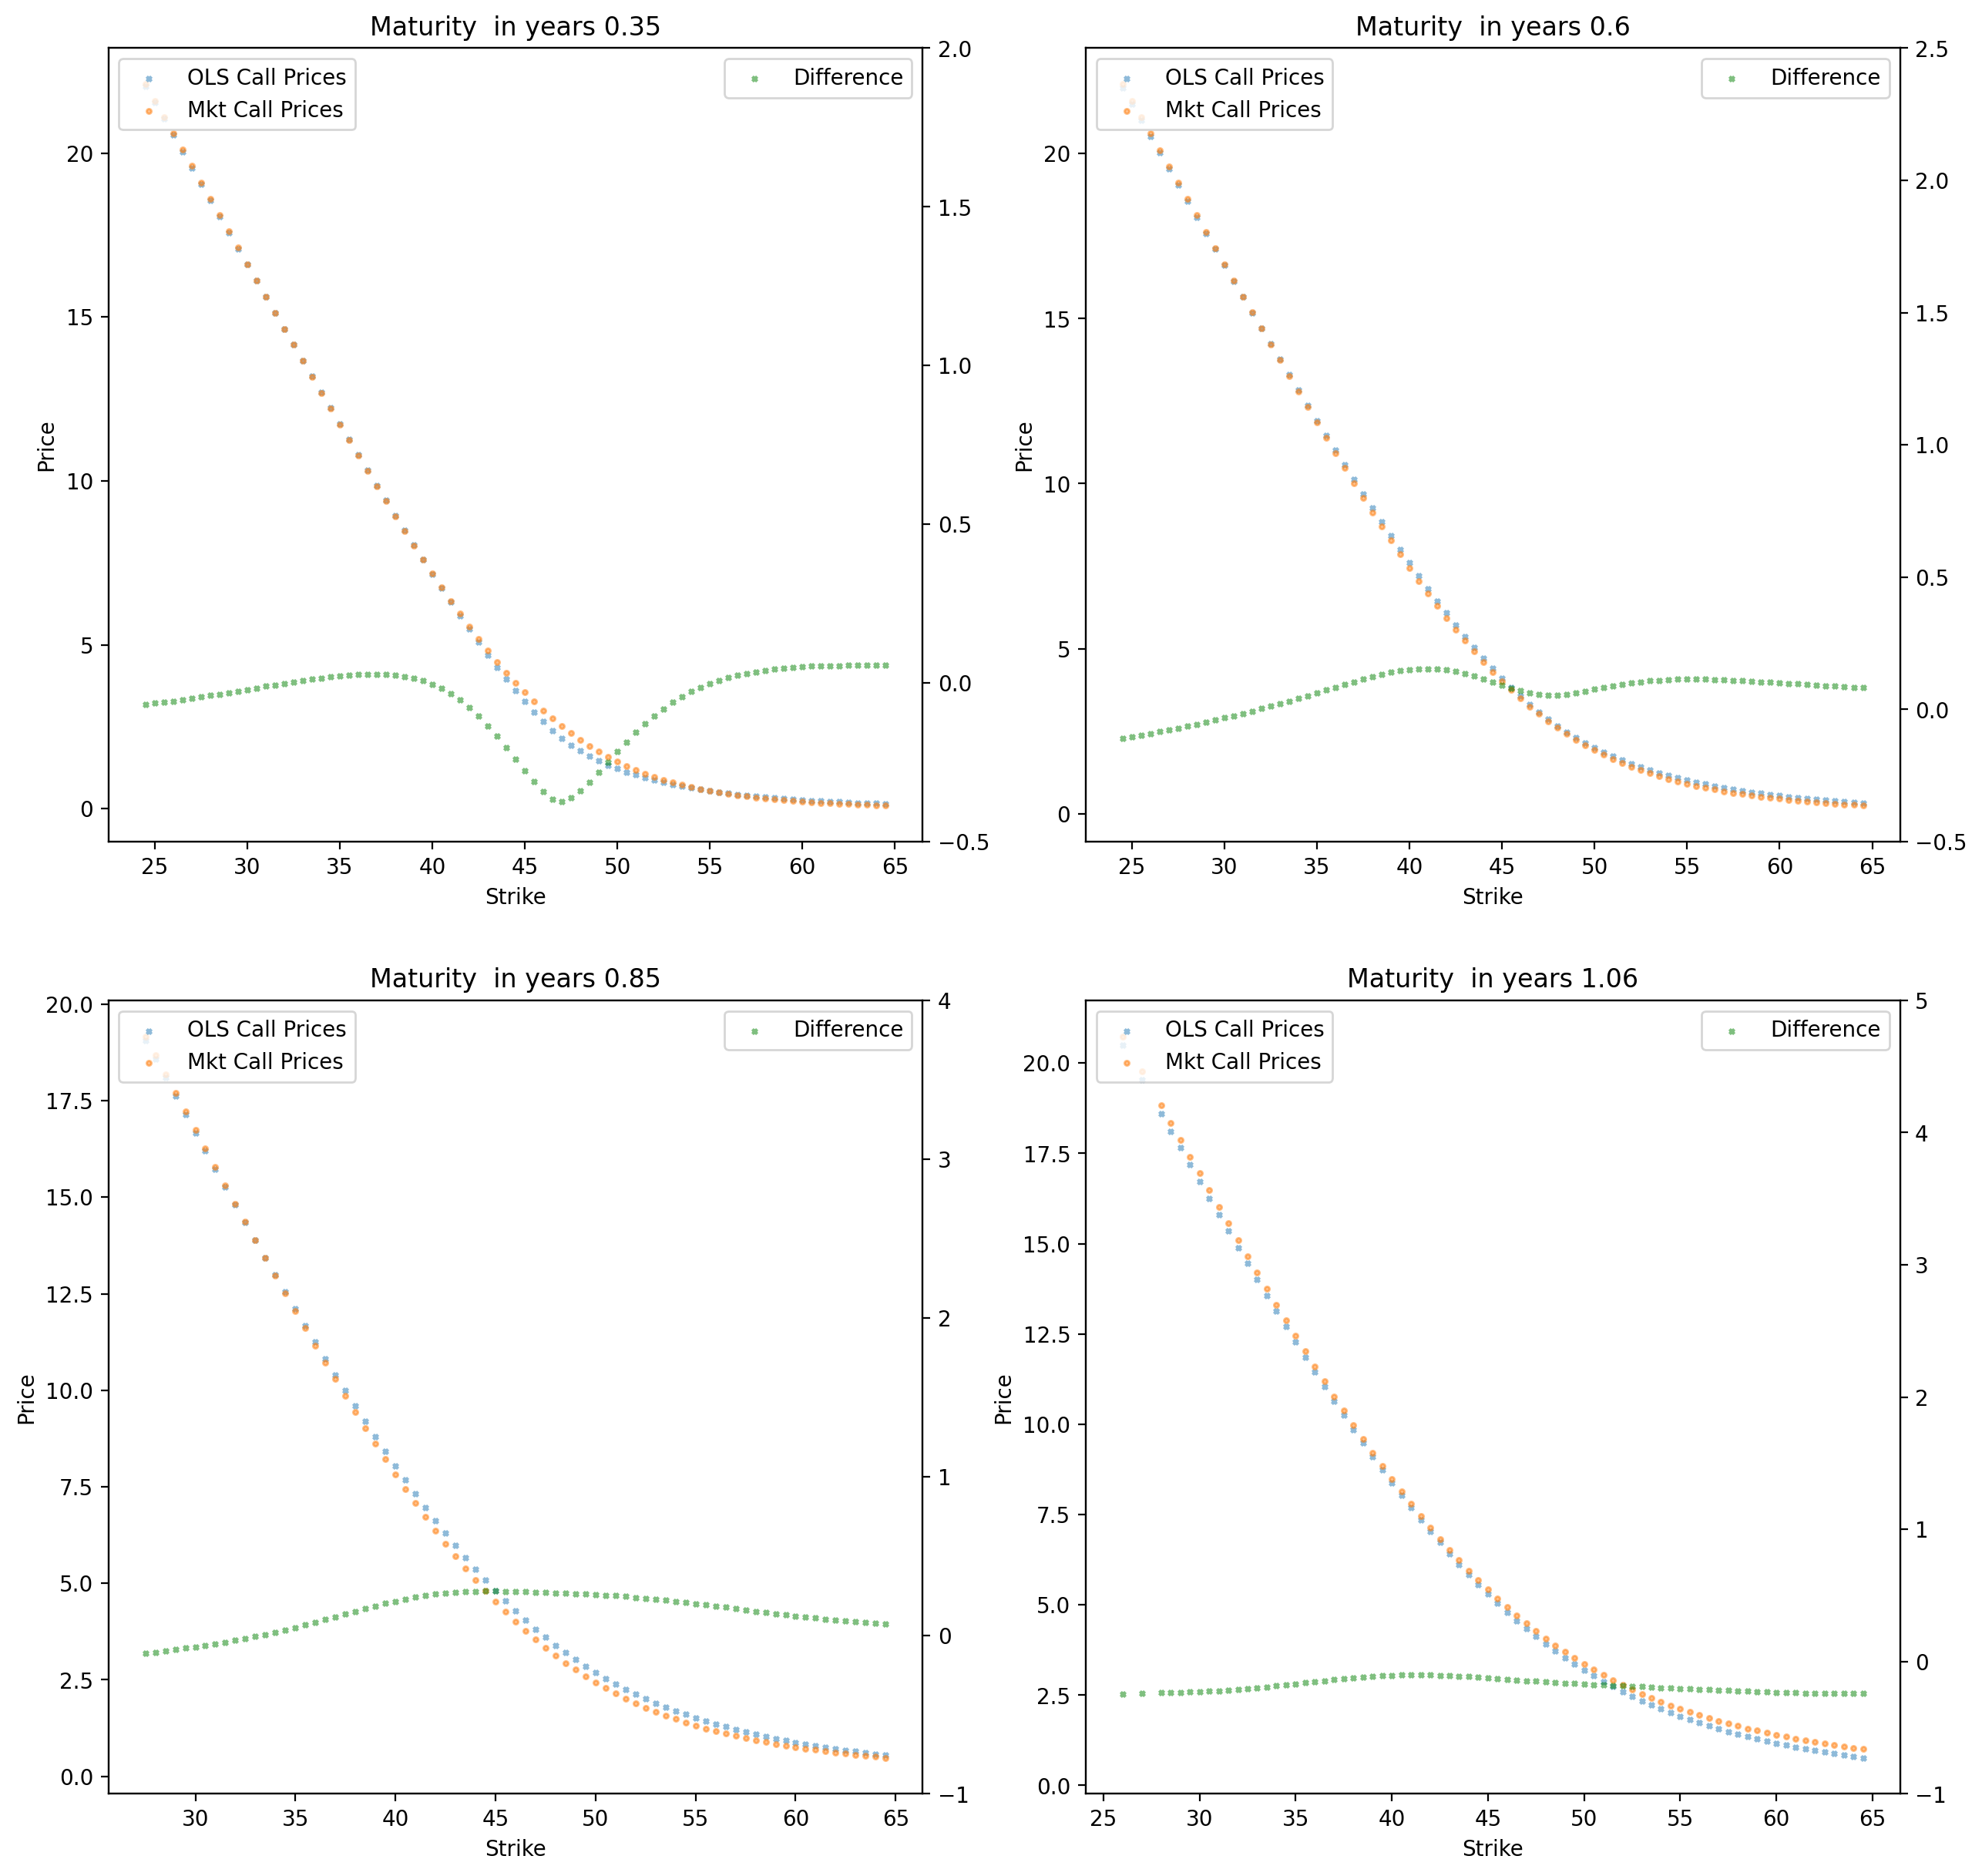

In [20]:
def plot_prices(P_ols):
    
    # One plot for each maturity

    t0 = df_fwd.TradingDate.values[0]
    maturities = df_opt.ExpiryDate
    T = (maturities - t0).dt.days/365
    K = df_opt.Strike
    P = df_opt.SettlementPrice    
    dif_Ps = P_ols-P
    
    Tunique = np.unique(T)
    
    fig, axs = plt.subplots(2, 2, figsize=(15,15))
    
    
    axs[0, 0].set_title('Maturity  in years '+ str(round(Tunique[0],2)) )
    axs[0, 0].scatter(K[T==Tunique[0]], P_ols[T==Tunique[0]], label = 'OLS Call Prices', marker='x', alpha=0.5, s=5)
    axs[0, 0].scatter(K[T==Tunique[0]], P[T==Tunique[0]], label = 'Mkt Call Prices', alpha=0.5, s=5)
    axs[0, 0].set_xlabel('Strike')
    axs[0, 0].set_ylabel('Price')
    axs[0, 0].legend(loc='upper left')
    ax0 = axs[0, 0].twinx()
    ax0.scatter(K[T==Tunique[0]], dif_Ps[T==Tunique[0]], label = 'Difference', marker='x', alpha=0.5, s=5, color='green')
    ax0.set_ylim([-0.5, 2])
    ax0.legend(loc='upper right')
    
    axs[0, 1].set_title('Maturity  in years '+ str(round(Tunique[1],2)) )
    axs[0, 1].scatter(K[T==Tunique[1]], P_ols[T==Tunique[1]], label = 'OLS Call Prices', marker='x', alpha=0.5, s=5)
    axs[0, 1].scatter(K[T==Tunique[1]], P[T==Tunique[1]], label = 'Mkt Call Prices', alpha=0.5, s=5)
    axs[0, 1].set_xlabel('Strike')
    axs[0, 1].set_ylabel('Price')
    axs[0, 1].legend(loc='upper left')
    ax1 = axs[0, 1].twinx()
    ax1.scatter(K[T==Tunique[1]], dif_Ps[T==Tunique[1]], label = 'Difference', marker='x', alpha=0.5, s=5, color='green')
    ax1.set_ylim([-0.5, 2.5])
    ax1.legend(loc='upper right')
    
    axs[1, 0].set_title('Maturity  in years '+ str(round(Tunique[2],2)) )
    axs[1, 0].scatter(K[T==Tunique[2]], P_ols[T==Tunique[2]], label = 'OLS Call Prices', marker='x', alpha=0.5, s=5)
    axs[1, 0].scatter(K[T==Tunique[2]], P[T==Tunique[2]], label = 'Mkt Call Prices', alpha=0.5, s=5)
    axs[1, 0].set_xlabel('Strike')
    axs[1, 0].set_ylabel('Price')
    axs[1, 0].legend(loc='upper left')
    ax2 = axs[1, 0].twinx()
    ax2.scatter(K[T==Tunique[2]], dif_Ps[T==Tunique[2]], label = 'Difference', marker='x', alpha=0.5, s=5, color='green')
    ax2.set_ylim([-1, 4])
    ax2.legend(loc='upper right')
    
    axs[1, 1].set_title('Maturity  in years '+ str(round(Tunique[3],2)) )
    axs[1, 1].scatter(K[T==Tunique[3]], P_ols[T==Tunique[3]], label = 'OLS Call Prices', marker='x', alpha=0.5, s=5)
    axs[1, 1].scatter(K[T==Tunique[3]], P[T==Tunique[3]], label = 'Mkt Call Prices', alpha=0.5, s=5)
    axs[1, 1].set_xlabel('Strike')
    axs[1, 1].set_ylabel('Price')
    axs[1, 1].legend(loc='upper left')
    ax3 = axs[1, 1].twinx()
    ax3.scatter(K[T==Tunique[3]], dif_Ps[T==Tunique[3]], label = 'Difference', marker='x', alpha=0.5, s=5, color='green')
    ax3.set_ylim([-1, 5])
    ax3.legend(loc='upper right')
    
    plt.show()


plot_prices(P_ols)

### End :D